# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

In [33]:
import pandas as pd

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.analysis_basics import check_constraints as check
from src.utils.rolling_process.rolling_filter import *

from src.utils.editor import enrich_schedule_dframe

# Solver
from src.solvers.converter import get_job_ops_dict, get_times_dict, get_schedule_dframe, get_active_ops
from src.solvers.cp.lateness import solve_jssp_lateness_with_start_deviation_minimization, \
    solve_jssp_lateness_with_order_deviation_minimization

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [34]:
# Hard termination condition for schedulers
max_time = 60*3     # 3 min

# File paths
examples_data_path = get_path("data", "examples")
basic_data_path = get_path("data", "basic")

# Simulation
simulation = ProductionSimulation(sigma = 0.2)

In [35]:
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [36]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,79,1440,597,3660
1,J25-0001,6,129,1440,416,2338
2,J25-0002,0,198,1440,395,3744
3,J25-0003,2,243,1440,568,3379
4,J25-0004,3,287,1440,655,4856
5,J25-0005,1,498,1440,510,3106
...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,655,520389
7245,J25-7245,9,518089,518400,540,519640
7246,J25-7246,6,518116,518400,416,520157


## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [37]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [38]:
# New and unfinished jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,79,1440,597,3660
1,J25-0001,6,129,1440,416,2338
2,J25-0002,0,198,1440,395,3744
3,J25-0003,2,243,1440,568,3379
4,J25-0004,3,287,1440,655,4856
5,J25-0005,1,498,1440,510,3106
6,J25-0006,9,790,1440,540,3539
7,J25-0007,5,925,1440,496,2929
8,J25-0008,4,988,1440,393,3541
9,J25-0009,7,1004,1440,539,3578


In [39]:
# current JSSP (Job Shop Scheduling Problem) basic data
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current, exclusion_dataframes_list = None)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling Preperation

In [40]:
job_ops_dict = get_job_ops_dict(df_jssp_current)
job_ops_dict

{'J25-0000': [(0, 'M00', 76),
  (1, 'M01', 69),
  (2, 'M03', 76),
  (3, 'M05', 51),
  (4, 'M02', 85),
  (5, 'M09', 11),
  (6, 'M06', 40),
  (7, 'M07', 89),
  (8, 'M04', 26),
  (9, 'M08', 74)],
 'J25-0001': [(0, 'M01', 46),
  (1, 'M00', 37),
  (2, 'M03', 61),
  (3, 'M02', 13),
  (4, 'M06', 32),
  (5, 'M05', 21),
  (6, 'M09', 32),
  (7, 'M08', 89),
  (8, 'M07', 30),
  (9, 'M04', 55)],
 'J25-0002': [(0, 'M00', 29),
  (1, 'M01', 78),
  (2, 'M02', 9),
  (3, 'M03', 36),
  (4, 'M04', 49),
  (5, 'M05', 11),
  (6, 'M06', 62),
  (7, 'M07', 56),
  (8, 'M08', 44),
  (9, 'M09', 21)],
 'J25-0003': [(0, 'M01', 91),
  (1, 'M00', 85),
  (2, 'M03', 39),
  (3, 'M02', 74),
  (4, 'M08', 90),
  (5, 'M05', 10),
  (6, 'M07', 12),
  (7, 'M06', 89),
  (8, 'M09', 45),
  (9, 'M04', 33)],
 'J25-0004': [(0, 'M01', 81),
  (1, 'M02', 95),
  (2, 'M00', 71),
  (3, 'M04', 99),
  (4, 'M06', 9),
  (5, 'M08', 52),
  (6, 'M07', 85),
  (7, 'M03', 98),
  (8, 'M09', 22),
  (9, 'M05', 43)],
 'J25-0005': [(0, 'M00', 43),
  (1, '

In [41]:
times_dict = get_times_dict(df_jobs_times_current)
times_dict

{'J25-0000': (1440, 3660),
 'J25-0001': (1440, 2338),
 'J25-0002': (1440, 3744),
 'J25-0003': (1440, 3379),
 'J25-0004': (1440, 4856),
 'J25-0005': (1440, 3106),
 'J25-0006': (1440, 3539),
 'J25-0007': (1440, 2929),
 'J25-0008': (1440, 3541),
 'J25-0009': (1440, 3578),
 'J25-0010': (1440, 3345),
 'J25-0011': (1440, 3210),
 'J25-0012': (1440, 4385),
 'J25-0013': (1440, 2567),
 'J25-0014': (1440, 3315),
 'J25-0015': (1440, 2981)}

### Schedule

In [42]:
schedule = solve_jssp_lateness_with_start_deviation_minimization(
        job_ops=job_ops_dict,
        times_dict=times_dict,
        previous_schedule=None,
        active_ops=None,
        w_t= 10, w_e=2, w_first=1,
        main_pct=1, duration_buffer_factor = 2,
        schedule_start=day_start, msg=False,
        solver_time_limit=max_time, solver_relative_gap_limit=0.05
    )

Model Information
  Number of variables       : 421
  Number of constraints     : 575
  Deviation terms (IntVars) : 0

Solver Information:
  Status                   : OPTIMAL
  Objective value          : 0.0
  Best objective bound     : 0.0
  Number of branches       : 0
  Wall time                : 0.033573700000000005


In [43]:
df_schedule = get_schedule_dframe(schedule)
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_01.csv", index=False)
df_schedule

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,2481,76,2557
1,J25-0000,1,M01,2594,69,2663
2,J25-0000,2,M03,2681,76,2757
3,J25-0000,3,M05,2783,51,2834
4,J25-0000,4,M02,2834,85,2919
5,J25-0000,5,M09,2970,11,2981
...,...,...,...,...,...,...
154,J25-0015,4,M08,2277,48,2325
155,J25-0015,5,M09,2325,72,2397
156,J25-0015,6,M00,2434,47,2481


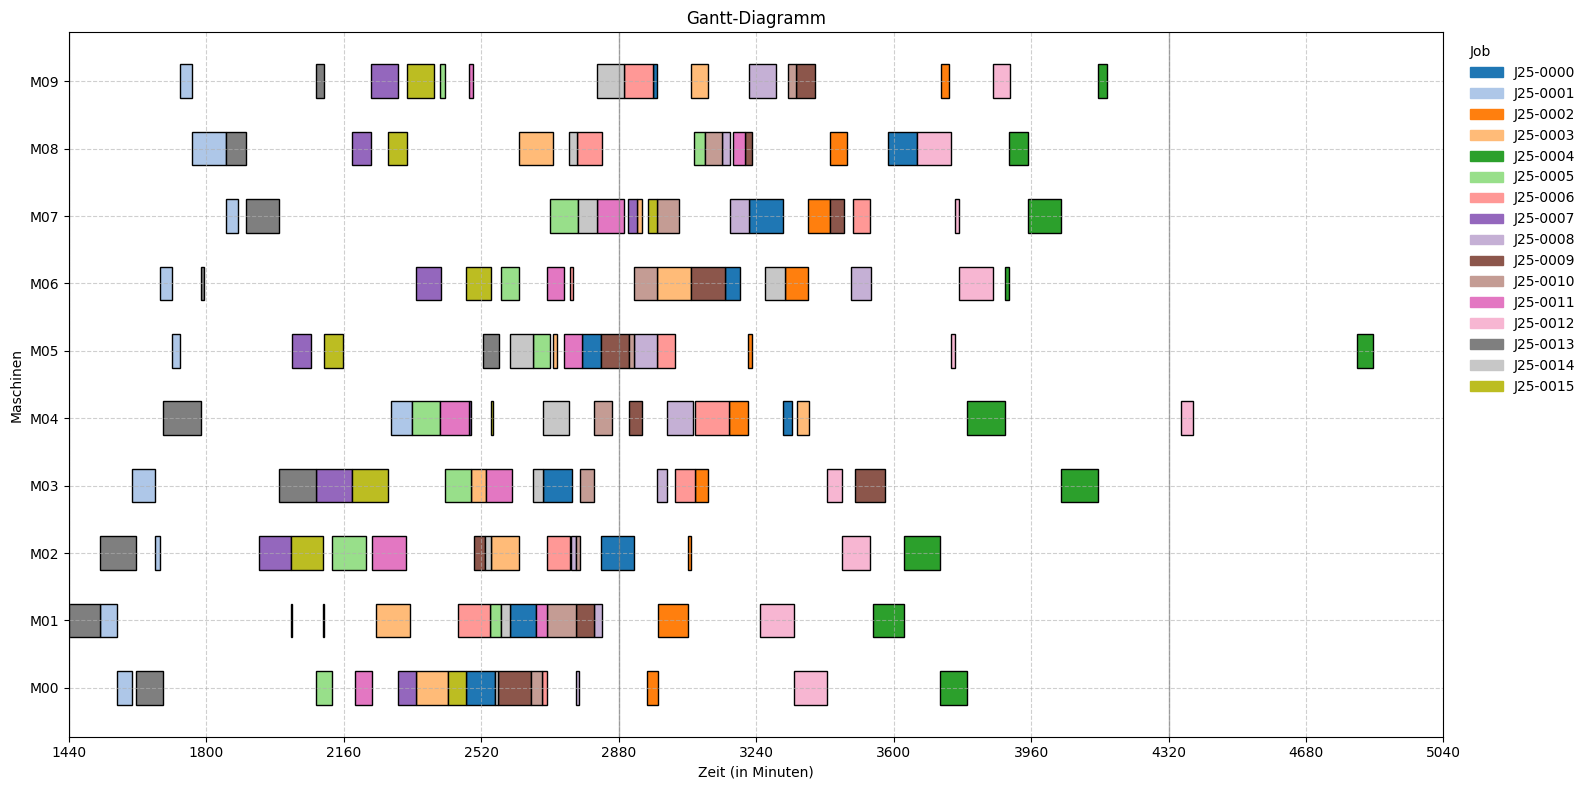

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



True

In [44]:
gantt.get_plot(df_schedule, perspective="Machine")

df_schedule_with_info = enrich_schedule_dframe(df_schedule, df_jobs_times)
check.all_in_one(df_schedule_with_info)


### Simulation

In [45]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 01:08:00] Job J25-0013 finished on M01 (after 68 minutes)
[Day 1 01:21:00] Job J25-0001 started on M01
[Day 1 01:21:00] Job J25-0013 started on M02
[Day 1 02:00:00] Job J25-0001 finished on M01 (after 39 minutes)
[Day 1 02:07:00] Job J25-0001 started on M00
[Day 1 02:41:00] Job J25-0001 finished on M00 (after 34 minutes)
[Day 1 02:44:00] Job J25-0013 finished on M02 (after 83 minutes)
[Day 1 02:44:00] Job J25-0001 started on M03
[Day 1 02:56:00] Job J25-0013 started on M00
[Day 1 03:39:00] Job J25-0013 finished on M00 (after 43 minutes)
[Day 1 03:48:00] Job J25-0001 finished on M03 (after 64 minutes)
[Day 1 03:48:00] Job J25-0001 started on M02
[Day 1 04:02:00] Job J25-0001 finished on M02 (after 14 minutes)
[Day 1 04:02:00] Job J25-0001 started on M06
[Day 1 04:07:00] Job J25-0013 started on M04
[Day 1 04:26:00] Job J25-0001 finished on M06 (after 24 minutes)
[Day 1 04:30:00] Job J25-0001 started on M05
[Day 1 04:45:00] Job J25-0001 

In [46]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,2537.0,60.0,2597.0
1,J25-0000,1,M01,2597.0,85.0,2682.0
2,J25-0000,2,M03,2682.0,73.0,2755.0
3,J25-0000,3,M05,2783.0,43.0,2826.0
4,J25-0001,0,M01,1521.0,39.0,1560.0
5,J25-0001,1,M00,1567.0,34.0,1601.0
...,...,...,...,...,...,...
75,J25-0015,3,M03,2218.0,77.0,2295.0
76,J25-0015,4,M08,2295.0,55.0,2350.0
77,J25-0015,5,M09,2350.0,82.0,2432.0


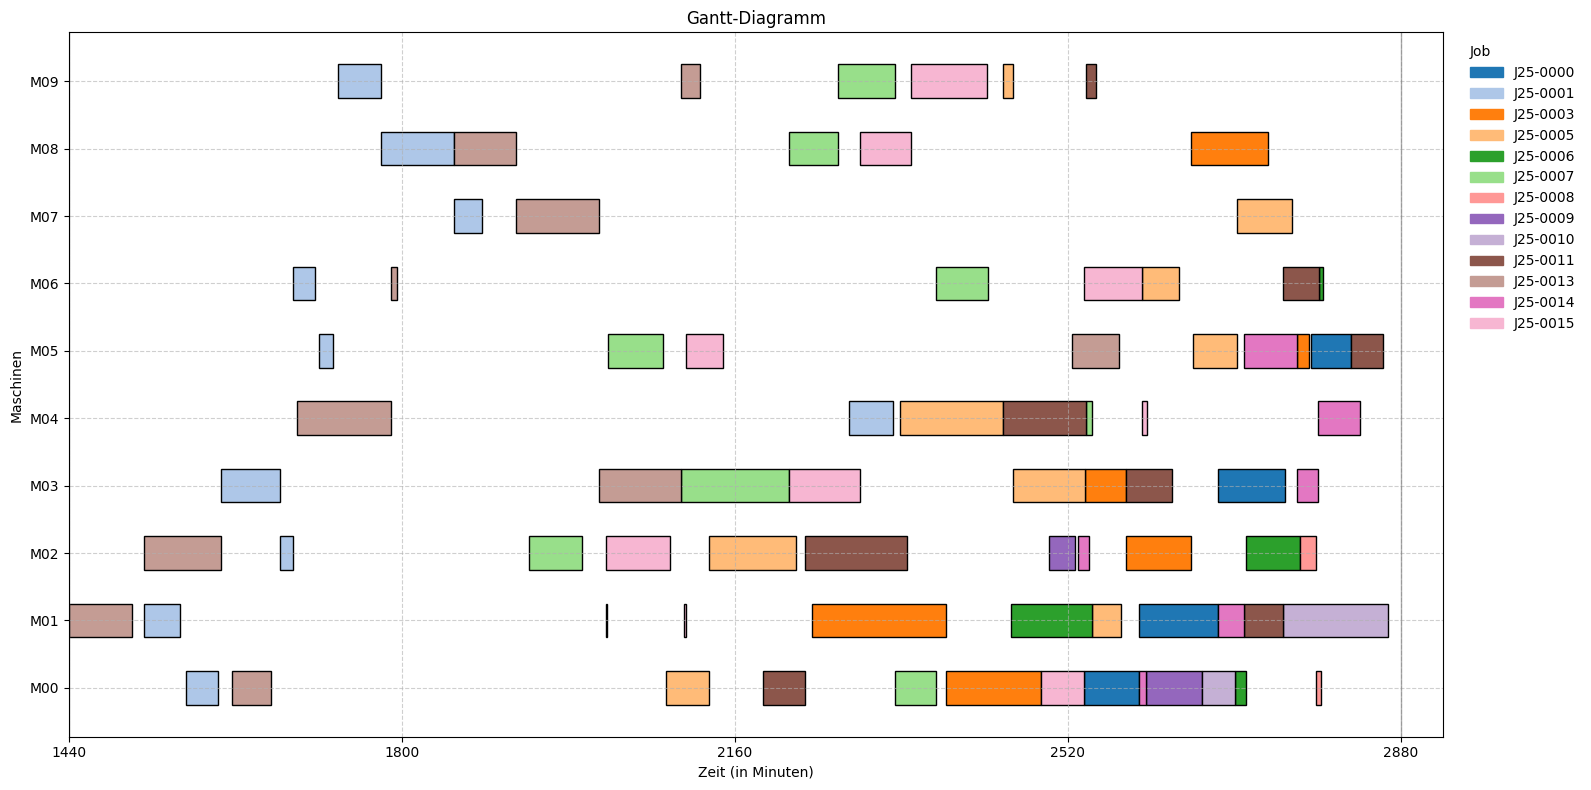

In [47]:
gantt.get_plot(df_execution, perspective="Machine")

In [48]:
df_active = simulation.get_active_operations_df()
df_active

,Job,Operation,Machine,Start,Processing Time,End,Expected End
0,J25-0000,4,M02,2834.0,82.0,2916.0,2919.0
1,J25-0006,4,M08,2796.0,84.0,2880.0,2860.0
2,J25-0009,2,M01,2866.0,62.0,2928.0,2912.0
3,J25-0011,8,M07,2861.0,53.0,2914.0,2933.0


In [49]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,5,M09,2970,11,2981
1,J25-0000,6,M06,3158,40,3198
2,J25-0000,7,M07,3220,89,3309
3,J25-0000,8,M04,3309,26,3335
4,J25-0000,9,M08,3586,74,3660
5,J25-0002,0,M00,2954,29,2983
...,...,...,...,...,...,...
69,J25-0012,9,M04,4352,33,4385
70,J25-0014,6,M08,2750,21,2771
71,J25-0014,7,M07,2773,49,2822


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [50]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [51]:
# New and unfinished jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,79,1440,597,3660
2,J25-0002,0,198,1440,395,3744
3,J25-0003,2,243,1440,568,3379
4,J25-0004,3,287,1440,655,4856
5,J25-0005,1,498,1440,510,3106
6,J25-0006,9,790,1440,540,3539
...,...,...,...,...,...,...
32,J25-0032,6,2654,2880,416,3881
33,J25-0033,2,2660,2880,568,6738
34,J25-0034,8,2715,2880,597,6387


In [52]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
5,J25-0000,8,5,M09,11
6,J25-0000,8,6,M06,40
7,J25-0000,8,7,M07,89
8,J25-0000,8,8,M04,26
9,J25-0000,8,9,M08,74
20,J25-0002,0,0,M00,29
...,...,...,...,...,...
374,J25-0037,7,4,M04,32
375,J25-0037,7,5,M06,88
376,J25-0037,7,6,M08,19


### Scheduling Preparation

In [53]:
job_ops_dict = get_job_ops_dict(df_jssp_current)
job_ops_dict

{'J25-0000': [(5, 'M09', 11),
  (6, 'M06', 40),
  (7, 'M07', 89),
  (8, 'M04', 26),
  (9, 'M08', 74)],
 'J25-0002': [(0, 'M00', 29),
  (1, 'M01', 78),
  (2, 'M02', 9),
  (3, 'M03', 36),
  (4, 'M04', 49),
  (5, 'M05', 11),
  (6, 'M06', 62),
  (7, 'M07', 56),
  (8, 'M08', 44),
  (9, 'M09', 21)],
 'J25-0003': [(6, 'M07', 12), (7, 'M06', 89), (8, 'M09', 45), (9, 'M04', 33)],
 'J25-0004': [(0, 'M01', 81),
  (1, 'M02', 95),
  (2, 'M00', 71),
  (3, 'M04', 99),
  (4, 'M06', 9),
  (5, 'M08', 52),
  (6, 'M07', 85),
  (7, 'M03', 98),
  (8, 'M09', 22),
  (9, 'M05', 43)],
 'J25-0005': [(9, 'M08', 30)],
 'J25-0006': [(5, 'M09', 76),
  (6, 'M05', 47),
  (7, 'M03', 52),
  (8, 'M04', 90),
  (9, 'M07', 45)],
 'J25-0007': [(9, 'M07', 25)],
 'J25-0008': [(2, 'M01', 22),
  (3, 'M05', 61),
  (4, 'M03', 26),
  (5, 'M04', 69),
  (6, 'M08', 21),
  (7, 'M07', 49),
  (8, 'M09', 72),
  (9, 'M06', 53)],
 'J25-0009': [(3, 'M05', 74),
  (4, 'M04', 32),
  (5, 'M06', 88),
  (6, 'M08', 19),
  (7, 'M09', 48),
  (8, 'M07

In [54]:
times_dict = get_times_dict(df_jobs_times_current)
times_dict

{'J25-0000': (1440, 3660),
 'J25-0002': (1440, 3744),
 'J25-0003': (1440, 3379),
 'J25-0004': (1440, 4856),
 'J25-0005': (1440, 3106),
 'J25-0006': (1440, 3539),
 'J25-0007': (1440, 2929),
 'J25-0008': (1440, 3541),
 'J25-0009': (1440, 3578),
 'J25-0010': (1440, 3345),
 'J25-0011': (1440, 3210),
 'J25-0012': (1440, 4385),
 'J25-0014': (1440, 3315),
 'J25-0015': (1440, 2981),
 'J25-0016': (2880, 4558),
 'J25-0017': (2880, 4980),
 'J25-0018': (2880, 4772),
 'J25-0019': (2880, 4621),
 'J25-0020': (2880, 4834),
 'J25-0021': (2880, 5368),
 'J25-0022': (2880, 4784),
 'J25-0023': (2880, 4676),
 'J25-0024': (2880, 4809),
 'J25-0025': (2880, 4780),
 'J25-0026': (2880, 4415),
 'J25-0027': (2880, 5711),
 'J25-0028': (2880, 5291),
 'J25-0029': (2880, 4675),
 'J25-0030': (2880, 6015),
 'J25-0031': (2880, 4377),
 'J25-0032': (2880, 3881),
 'J25-0033': (2880, 6738),
 'J25-0034': (2880, 6387),
 'J25-0035': (2880, 4126),
 'J25-0036': (2880, 5231),
 'J25-0037': (2880, 5173)}

In [55]:
active_ops = get_active_ops(df_active)
active_ops

[('J25-0000', 4, 'M02', 2834, 82, 2916),
 ('J25-0006', 4, 'M08', 2796, 84, 2880),
 ('J25-0009', 2, 'M01', 2866, 62, 2928),
 ('J25-0011', 8, 'M07', 2861, 53, 2914)]

In [56]:
previous_schedule = schedule

### Scheduling (Rescheduling)

#### a) Simple Scheduling

Model Information
  Number of variables       : 811
  Number of constraints     : 1083
  Deviation terms (IntVars) : 0

Solver Information:
  Status                   : OPTIMAL
  Objective value          : 150.0
  Best objective bound     : 150.0
  Number of branches       : 247
  Wall time                : 1.0630012


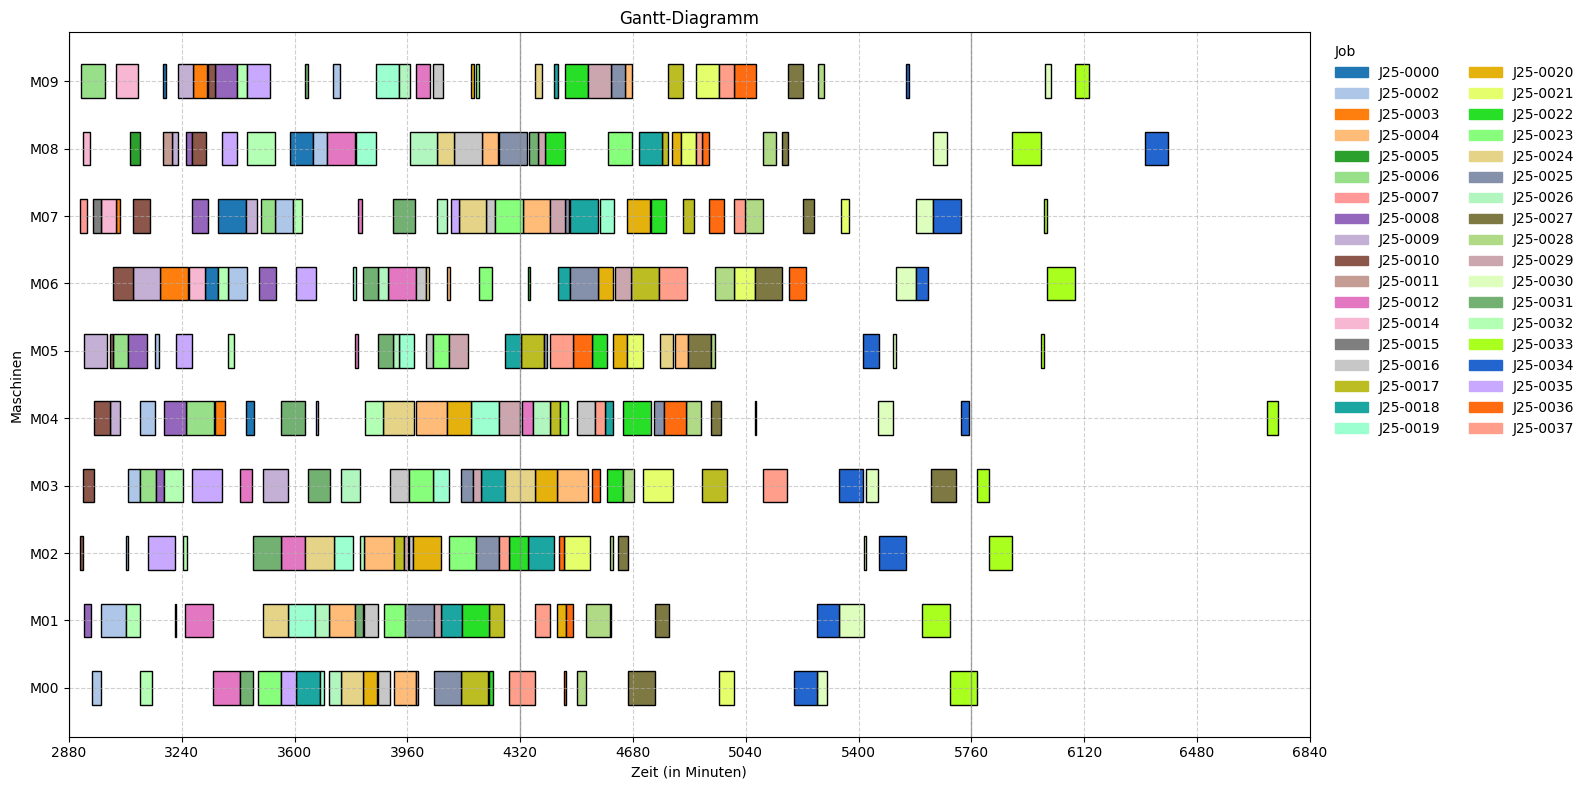

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



True

In [57]:
schedule = solve_jssp_lateness_with_start_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=None,
    active_ops=active_ops,
    w_t= 10, w_e=2, w_first=1,
    main_pct=1,
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")

df_schedule_with_info = enrich_schedule_dframe(df_schedule, df_jobs_times)
check.all_in_one(df_schedule_with_info)


### b) with 'start' deviation penalty

Model Information
  Number of variables       : 961
  Number of constraints     : 1233
  Deviation terms (IntVars) : 75

Solver Information:
  Status                   : OPTIMAL
  Objective value          : 9610.0
  Best objective bound     : 9131.0
  Number of branches       : 272
  Wall time                : 55.0870449


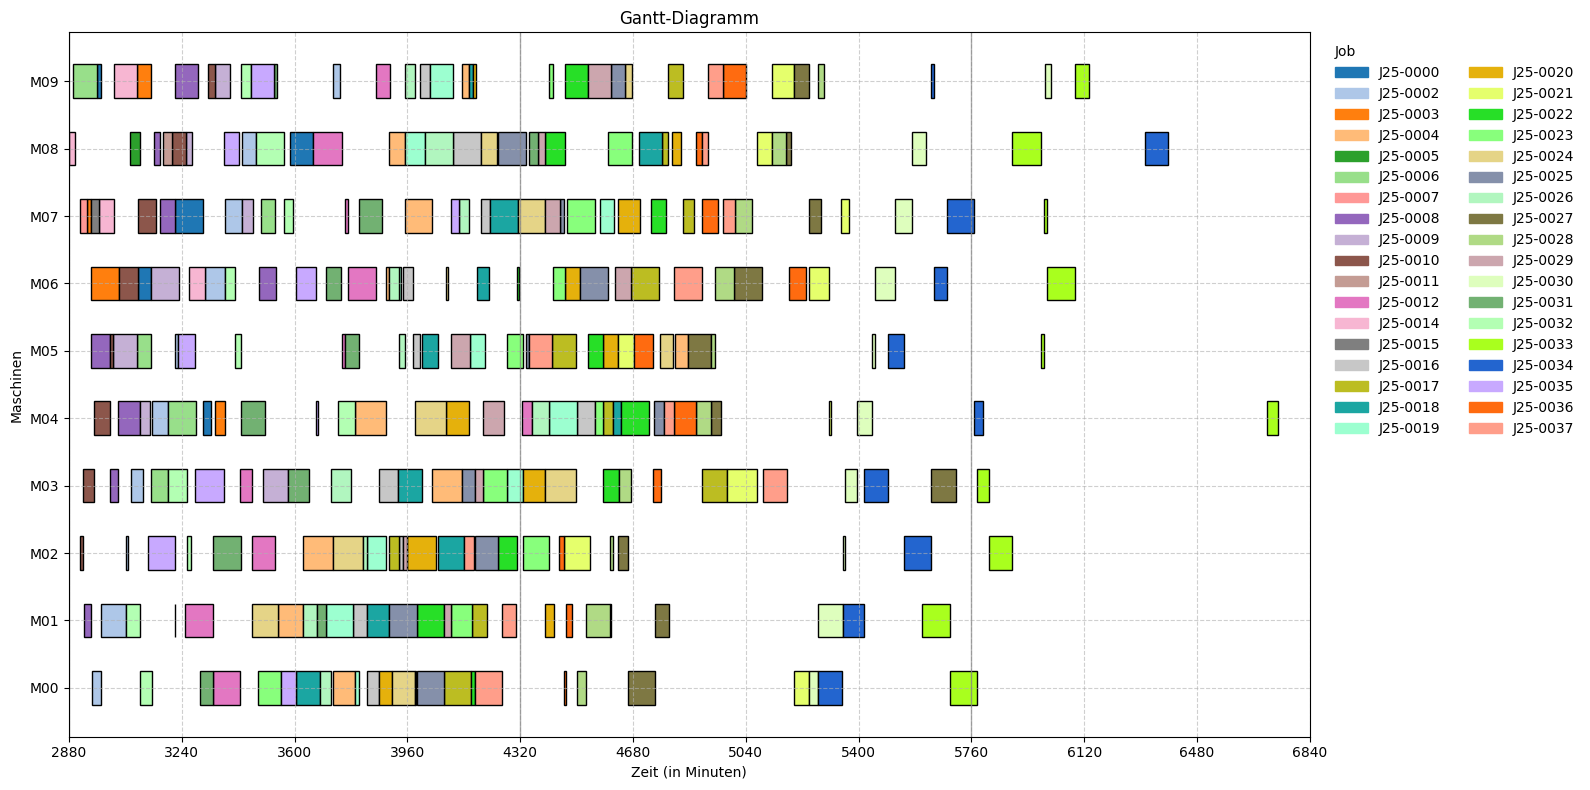

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



True

In [58]:
schedule = solve_jssp_lateness_with_start_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=previous_schedule,
    active_ops=active_ops,
    w_t= 10, w_e=2, w_first=1,
    main_pct=0.4,                  # 40% Lateness, 60% Deviation
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")

df_schedule_with_info = enrich_schedule_dframe(df_schedule, df_jobs_times)
check.all_in_one(df_schedule_with_info)


### c) with 'order on machines' deviation penalty

Model Information
  Number of variables       : 1096
  Number of constraints     : 1653
  Deviation terms (IntVars) : 285

Solver Information:
  Status                   : OPTIMAL
  Objective value          : 339.0
  Best objective bound     : 337.0
  Number of branches       : 826
  Wall time                : 2.791671


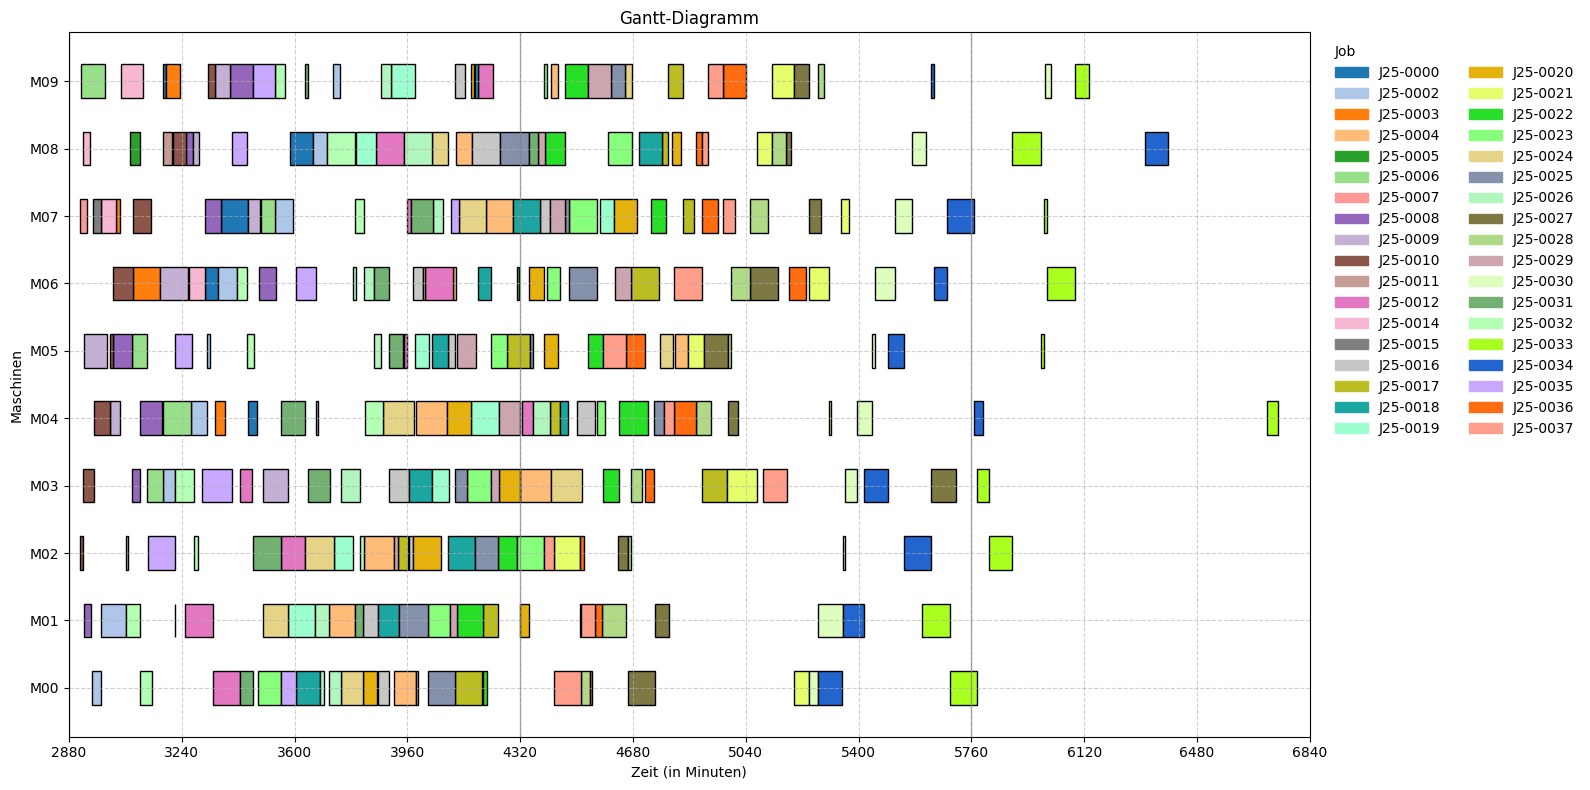

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



True

In [59]:
schedule = solve_jssp_lateness_with_order_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=previous_schedule,
    active_ops=active_ops,
    w_t= 10, w_e=2, w_first=1,
    main_pct=0.4,                  # 40% Lateness, 60% Deviation
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")

df_schedule_with_info = enrich_schedule_dframe(df_schedule, df_jobs_times)
check.all_in_one(df_schedule_with_info)

#### Check the conditions of the combined data set from the simulation data with the new schedule

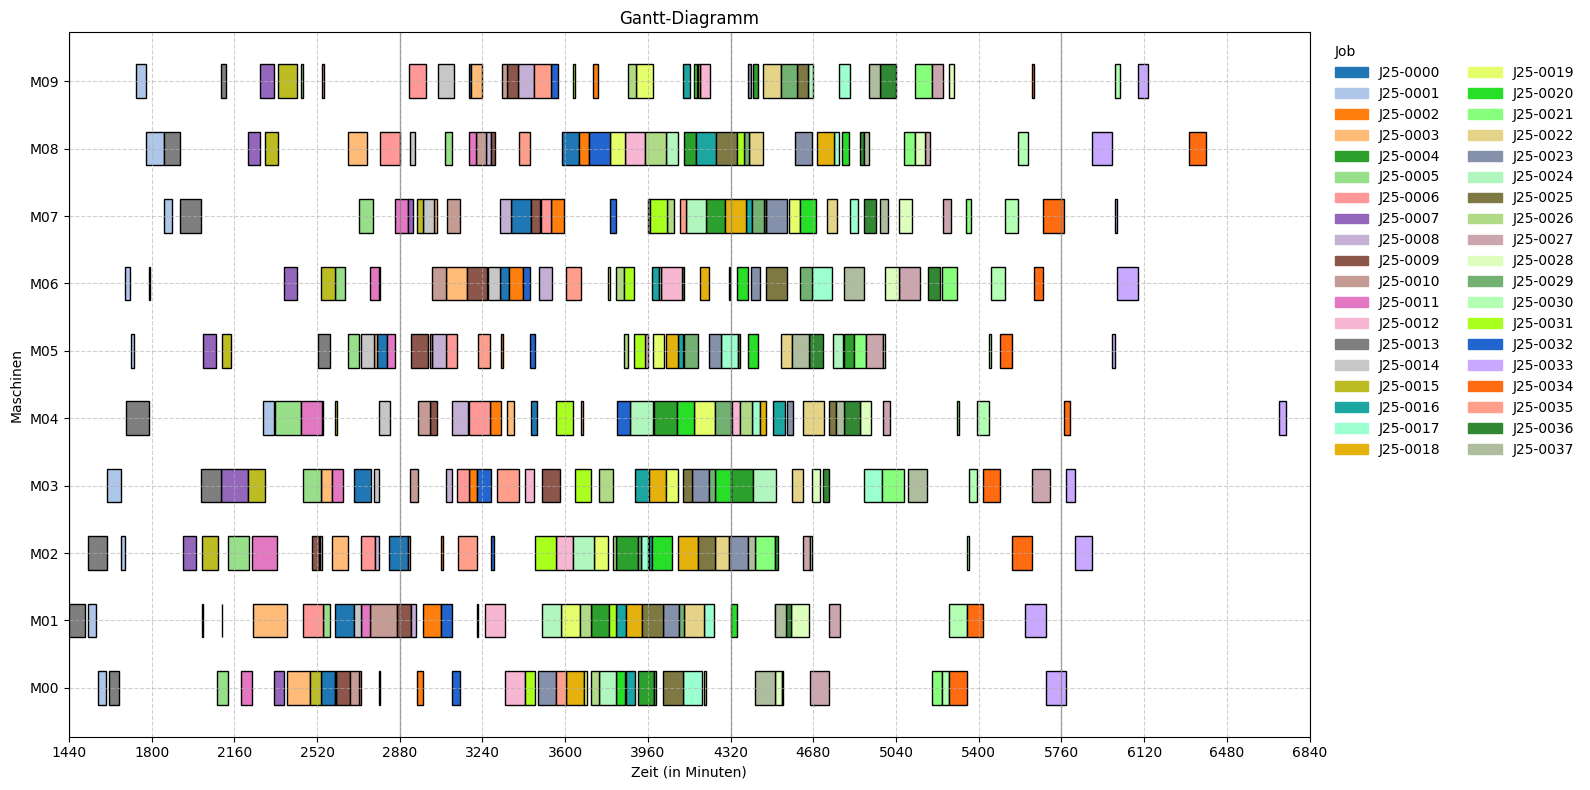

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.


True

In [60]:
df_reschedule = df_schedule_with_info

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)

### Simulation

In [61]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0006, Operation 4 resumed on M08 (with  left)
[Day 2 00:00:00] Job J25-0000, Operation 4 resumed on M02 (with 36 minutes left)
[Day 2 00:00:00] Job J25-0011, Operation 8 resumed on M07 (with 34 minutes left)
[Day 2 00:00:00] Job J25-0009, Operation 2 resumed on M01 (with 48 minutes left)
[Day 2 00:00:00] Job J25-0006 finished on M08 (after )
[Day 2 00:34:00] Job J25-0011 finished on M07 (after 34 minutes)
[Day 2 00:34:00] Job J25-0007 started on M07
[Day 2 00:36:00] Job J25-0000 finished on M02 (after 36 minutes)
[Day 2 00:36:00] Job J25-0010 started on M02
[Day 2 00:39:00] Job J25-0006 started on M09
[Day 2 00:45:00] Job J25-0010 finished on M02 (after 09 minutes)
[Day 2 00:45:00] Job J25-0014 started on M08
[Day 2 00:45:00] Job J25-0010 started on M03
[Day 2 00:48:00] Job J25-0009 finished on M01 (after 48 minutes)
[Day 2 00:48:00] Job J25-0008 started on M01
[Day 2 00:49:00] Job J25-0009 started on M05
[Day 2 01:03:00] Job J25-0007 finished on M07 (after 29 

In [62]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,4,M02,2834.0,82.0,2916.0
1,J25-0000,5,M09,3180.0,11.0,3191.0
2,J25-0000,6,M06,3370.0,48.0,3418.0
3,J25-0000,7,M07,3418.0,79.0,3497.0
4,J25-0000,8,M04,3497.0,27.0,3524.0
5,J25-0000,9,M08,3586.0,86.0,3672.0
...,...,...,...,...,...,...
156,J25-0035,4,M08,3399.0,38.0,3437.0
157,J25-0035,5,M09,3466.0,83.0,3549.0
158,J25-0035,6,M00,3558.0,58.0,3616.0


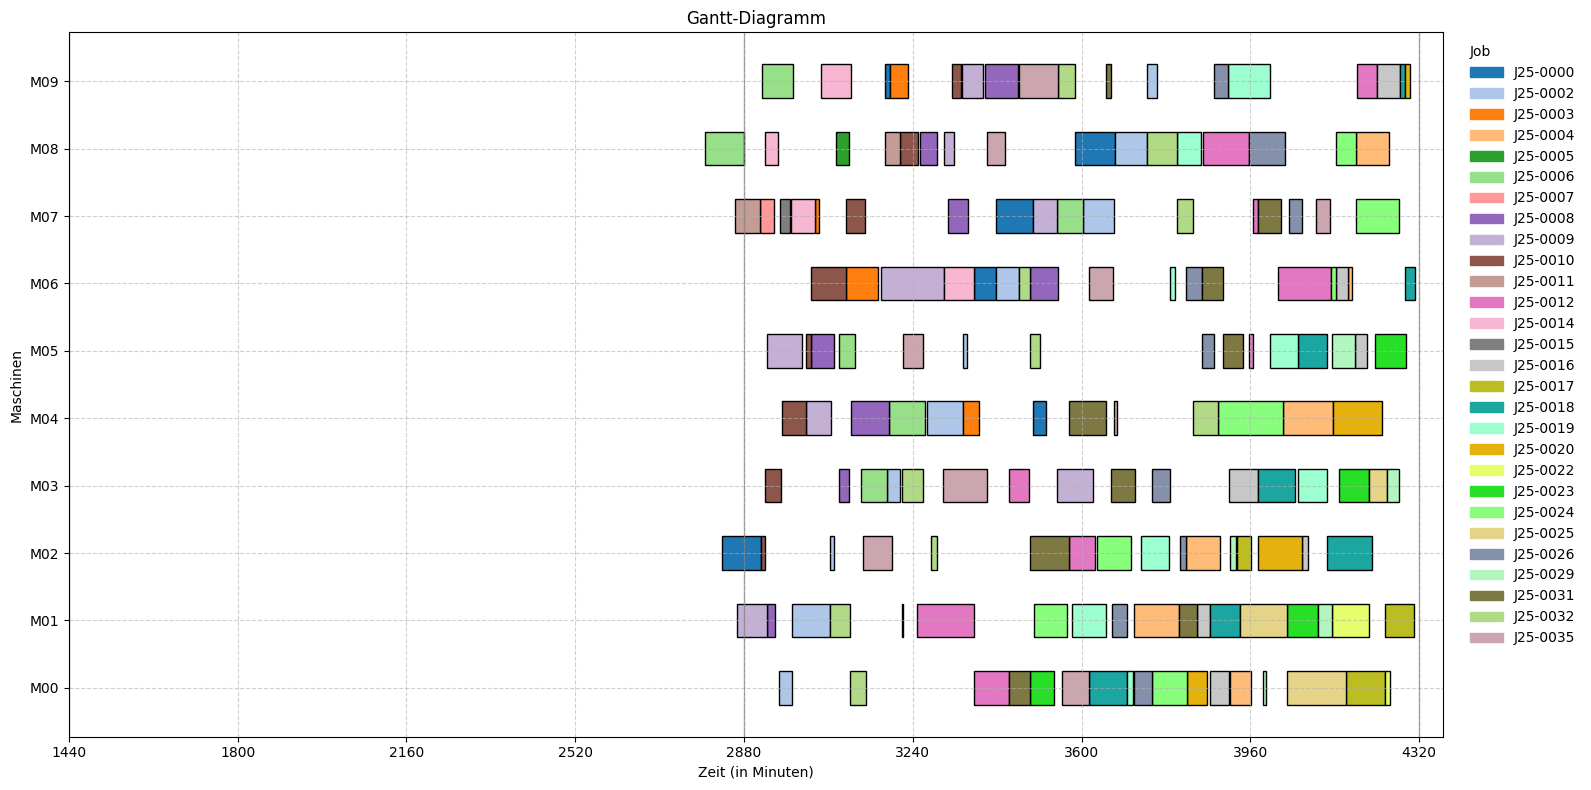

In [63]:
gantt.get_plot(df_execution2, perspective="Machine")

In [64]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Job,Operation,Machine,Start,Processing Time,End,Expected End
0,J25-0004,6,M07,4278.0,74.0,4352.0,4363.0
1,J25-0016,7,M08,4280.0,80.0,4360.0,4369.0
2,J25-0017,3,M05,4309.0,76.0,4385.0,4383.0
3,J25-0019,8,M04,4241.0,100.0,4341.0,4331.0
4,J25-0020,4,M03,4301.0,91.0,4392.0,4370.0
5,J25-0025,3,M02,4251.0,70.0,4321.0,4325.0


#### Check the conditions of the combined data set from the two simulation data sets

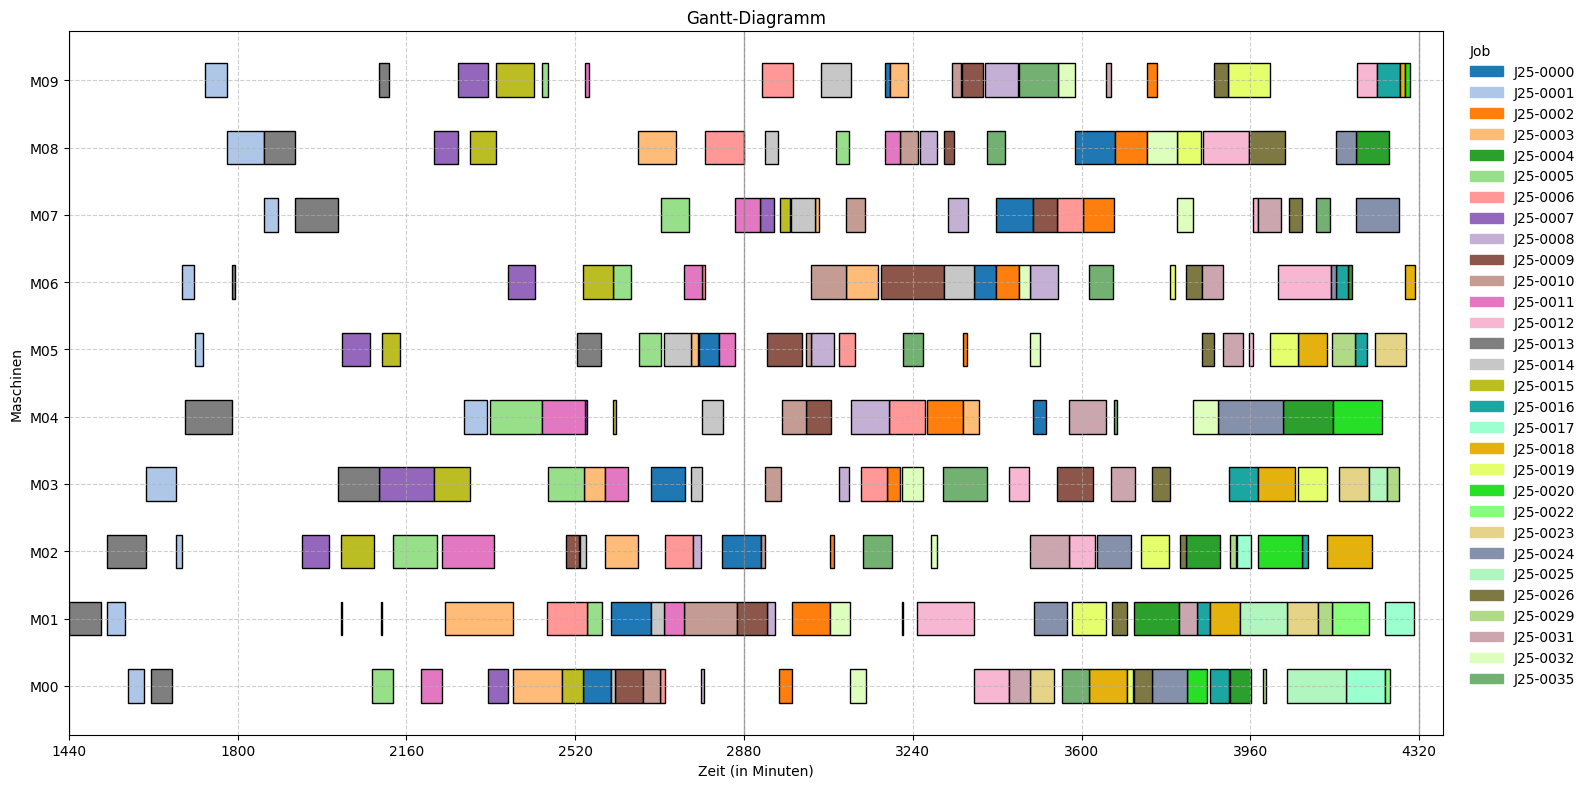

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.


True

In [65]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)